# Tarea Semanal 6: Estimación espectral. Ventanas en acción!
## Magdalena Noé
En esta tarea continuaremos con el capítulo 14 de Holton. DSP Principles and App.

Se trabajara sobre una señal con amplitud y frecuencia variable y se estimara su amplitud y frecuencia intrinseca con 4 tipos de ventanas:
- Rectangular (sin ventana)
- Flattop
- Blackmanharris
- Coseno
### Librerías

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft
from scipy.signal import windows

Parametros de la señal
Las variables aleateorias fr y na, correspondientes a la variacion de frecuencia y amplitud correspondientemente, se ven definidas por las siguientes distribuciones de probabilidad:

$$ fr∼U(−2,2);na∼N(0,σ^{2}) $$

In [ ]:
fs = 1000       # Frecuencia de muestreo [Hz]
N = fs          # cantidad de muestras

a0 = 2                              #Amplitud señal
sigma = np.sqrt(1/10)               # SNR de 10dB
na = np.random.normal(0, sigma, N)  #Incertidumbre de amplitud

omega0 = np.pi/2                        #Frecuencia señal [Hz]
fr = np.random.uniform(-2, 2, N)        #Incertidumbre de frecuencia
omega1 = omega0 + fr*((2*np.pi) / N)   #Frecuencia con incertidumbre


Generacion de señal

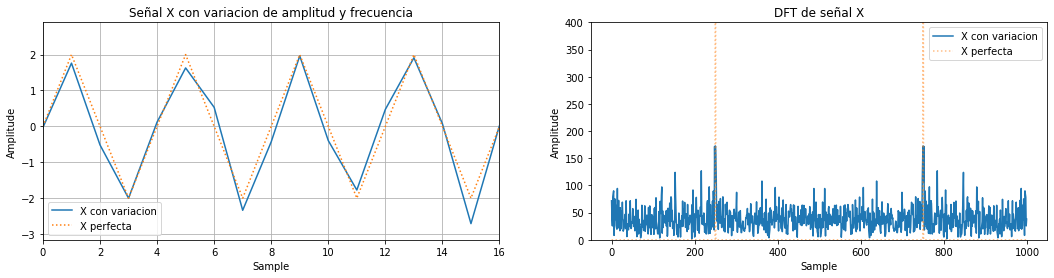

In [261]:
k = np.arange(N)                #Array de enteros de 0 a N-1
x = a0 * np.sin(omega1*k) + na  #
x_limpia= a0 * np.sin(omega0*k)

fft_x = np.abs(fft(x))
fft_x_limpia = np.abs(fft(x_limpia))

plt.figure(figsize=(18, 4))
plt.subplot(1,2,1)
plt.plot(x, label="X con variacion"); plt.plot(x_limpia, label="X perfecta", linestyle=':'); plt.title("Señal X con variacion de amplitud y frecuencia") 
plt.ylabel("Amplitude"); plt.xlabel("Sample"); plt.xlim(0, 4*(2*np.pi)/omega0); plt.legend(); plt.grid()
plt.subplot(1,2,2)
plt.plot(fft_x, label="X con variacion"); plt.plot(fft_x_limpia, label="X perfecta", linestyle=':', alpha=0.5); plt.title("DFT de señal X"); 
plt.ylabel("Amplitude"); plt.xlabel("Sample"); plt.legend(); plt.ylim(0,400)
plt.show()

Declaracion de las ventanas W

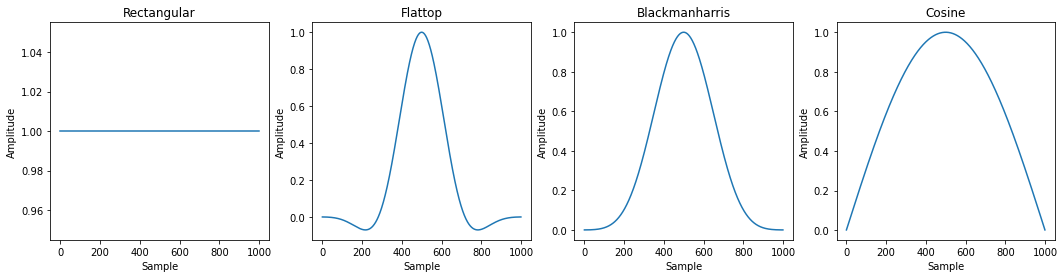

In [ ]:
Wrectangular = windows.boxcar(N)                # Arr de 1 constantes, sin ventana
Wflattop = windows.flattop(N)                   # Ventana flattop (sombrero de bruja)
Wblackmanharris = windows.blackmanharris(N)     # Ventana blackmanharris (campana)
Wcosine = windows.cosine(N)                     # Ventana cosine (medio coseno, loma)
arr_W = [Wrectangular, Wflattop, Wblackmanharris, Wcosine]
arr_titulos_W = ["Rectangular", "flattop", "blackmanharris", "cosine"]

# GRAFICOS
plt.figure(figsize=(18, 4))
plt.subplot(1,4,1); plt.plot(Wrectangular); plt.title("Rectangular"); plt.ylabel("Amplitude"); plt.xlabel("Sample")
plt.subplot(1,4,2); plt.plot(Wflattop); plt.title("Flattop"); plt.ylabel("Amplitude"); plt.xlabel("Sample")
plt.subplot(1,4,3); plt.plot(Wblackmanharris); plt.title("Blackmanharris"); plt.ylabel("Amplitude"); plt.xlabel("Sample")
plt.subplot(1,4,4); plt.plot(Wcosine); plt.title("Cosine"); plt.ylabel("Amplitude"); plt.xlabel("Sample")
plt.show()

### Estimamos la amplitud $a_0$ y la frecuencia $ \omega_0 $. 
En ambos analisis se realiz un ventaneo de la señal $X$, por lo que recorreremos los 4 casos de ventanas declaradas anteriormente.

Para estimar la amplitud se realiza la fft de la señal ventaneada y lee el indice correspondiente a $\omega_0 = \pi/2$. A dicha estimacion la llamaremos $a_1$

$$ a^i1=|Xiw(Ω0)|=|F{x(n)⋅wi(n)}| $$

Para estimar la frecuencia se detecta el maximo valor de espectro (fft) y retorna la frecuencia en radianes. A dicha estimacion la llamaremos $Ω_1$

$$ Ω^i1=arg max{|Xiw(Ω)|} $$


In [ ]:
def estimar_amplitud(x, w):
    xw = x * w # Ventaneo la señal
    modulo_xw = np.abs(fft(xw))
    omega0_ind = int(N // 4) # indice de omega0 = pi/2 -> frecuencia fo = fs/4 -> indice = N/4
    return modulo_xw[omega0_ind] # Retorno el valor modulo en pi/2 (pico de señal seno)

def estimar_frecuencia(x, w):
    xw = x * w
    modulo_xw = np.abs(fft(xw))
    f_ind = np.argmax(modulo_xw) #Retorna argumento con el maximo pico, que deberia corresponder a la frecuencia fundamental
    omega = 2 * np.pi * f_ind / N # Paso frecuencia a radianes/s
    return omega

print(f"Amplitud real: {a0:.2f}")
print(f"Frecuencia real: {(omega0/np.pi):.2f} π")
print("--------")

for i in np.arange(4):
    amplitud = (estimar_amplitud(x, arr_W[i]))
    frecuencia = (estimar_frecuencia(x, arr_W[i]))

    print(f"[Ventana {arr_titulos_W[i]}]")
    print(f"Amplitud estimada: {amplitud:.2f}")
    print(f"Frecuencia estimada: {(frecuencia/np.pi):.2f} π")
    print("--------")

Amplitud real: 2.00
Frecuencia real: 0.50 π
--------
[Ventana Rectangular]
Amplitud estimada: 172.61
Frecuencia estimada: 0.50 π
--------
[Ventana flattop]
Amplitud estimada: 26.43
Frecuencia estimada: 1.45 π
--------
[Ventana blackmanharris]
Amplitud estimada: 26.59
Frecuencia estimada: 0.50 π
--------
[Ventana cosine]
Amplitud estimada: 58.36
Frecuencia estimada: 1.50 π
--------


## Experimentación

Una vez ya declarada la señal, las ventanas a aplicarle y las funciones para obtener una estimacion de amplitud y frecuencia, vamos a correr esta estimacion 200 veces (cant_realizaciones) con 1000 muestras por experimento (N).

La SNR se parametrizara para 3dB, con una alta presencia de ruido, y 10 dB, es decir, con un ruido mas atenuado.
Para los 8 casos (4 ventanas y 2 tipos de SNR) se analizara:
- Sesgo amplitud: diferencia promedio entre valor estimado y el real ($a_0 = 2$)
- Varianza amplitud: cuánto varían las estimaciones de amplitud entre realizaciones
- Sesgo frecuencia: diferencia promedio entre frecuencia estimada y real ($ω0 = π/2$)
- Varianza frecuencia: cuánto se dispersan las estimaciones de frecuencia

In [264]:
cant_realizaciones = 200
SNR_dB = [3, 10]
SNR_lin = [10**(SNR_dB[0]/10), 10**(SNR_dB[1]/10)]

Realizo los siguientes bucles:
- ↳ **SNR (Casos 3dB y 10dB)**
Imprimo 2 tablas separadas con sesgo y varianza dependiendo del SNR indicado

    - ↳ **200 realizaciones** Recalculo variables de amplitud y frecuencia para tener 200 casos diferentes

        - ↳ **4 tipos de ventana** (Aplico c/u de las ventanas a la señal con nuevas variables aleatorias)
        Una vez ventaneado estimo ambos amplitud y frecuencia y guardo estos valores en un array separado para
        cada ventana


SNR = 3 dB
[SNR 1.995 - ventana Rectangular]
Sesgo amplitud: 122.61, Varianza amplitud: 1333.455
Sesgo frecuencia: 0.27 π, Varianza frecuencia: 1.970
--------


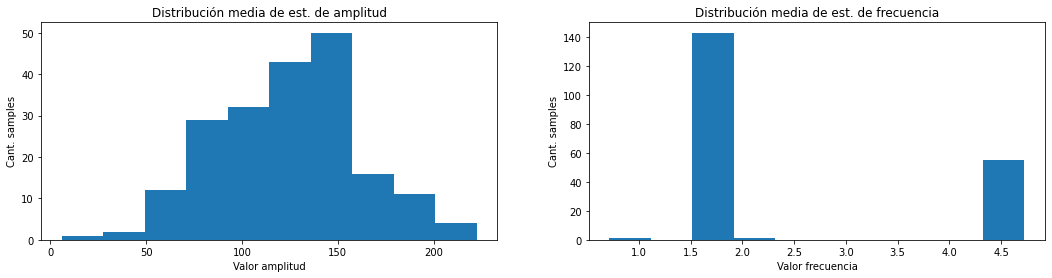

[SNR 1.995 - ventana flattop]
Sesgo amplitud: 16.87, Varianza amplitud: 90.710
Sesgo frecuencia: 0.24 π, Varianza frecuencia: 2.763
--------


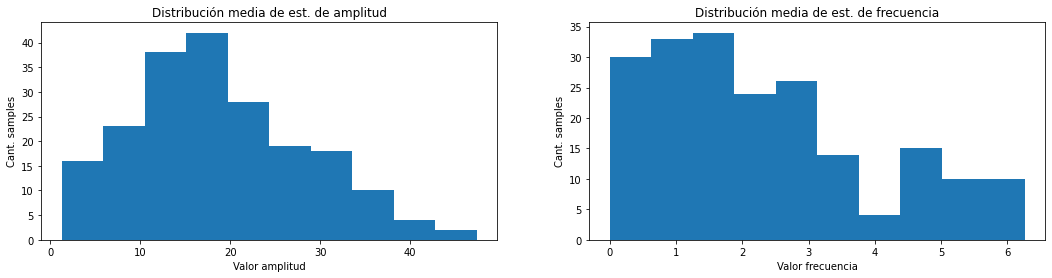

[SNR 1.995 - ventana blackmanharris]
Sesgo amplitud: 20.42, Varianza amplitud: 132.283
Sesgo frecuencia: 0.30 π, Varianza frecuencia: 3.055
--------


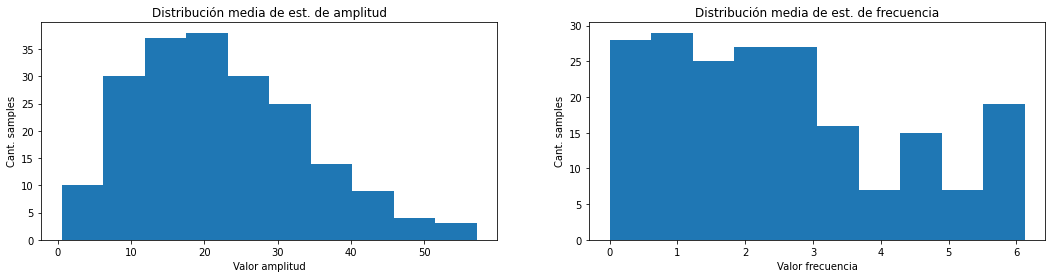

[SNR 1.995 - ventana cosine]
Sesgo amplitud: 35.38, Varianza amplitud: 373.431
Sesgo frecuencia: 0.27 π, Varianza frecuencia: 2.677
--------


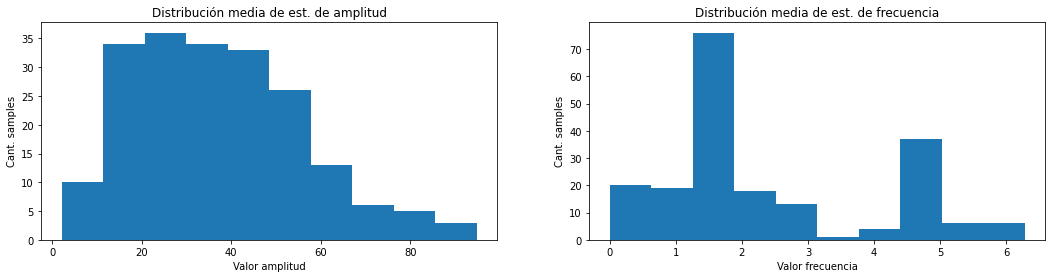


SNR = 10 dB
[SNR 10.000 - ventana Rectangular]
Sesgo amplitud: 122.49, Varianza amplitud: 957.857
Sesgo frecuencia: 0.38 π, Varianza frecuencia: 2.334
--------


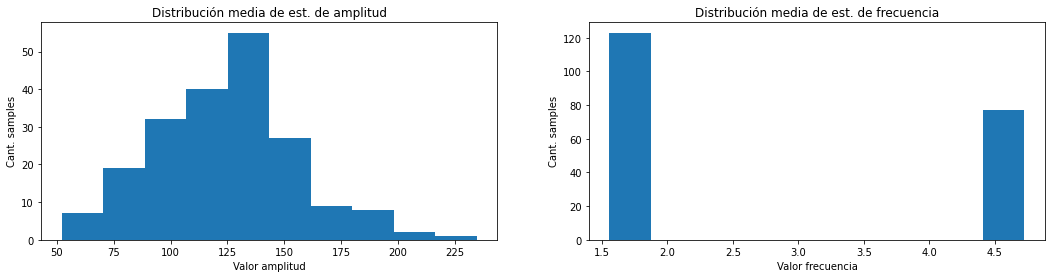

[SNR 10.000 - ventana flattop]
Sesgo amplitud: 16.15, Varianza amplitud: 84.139
Sesgo frecuencia: 0.21 π, Varianza frecuencia: 2.406
--------


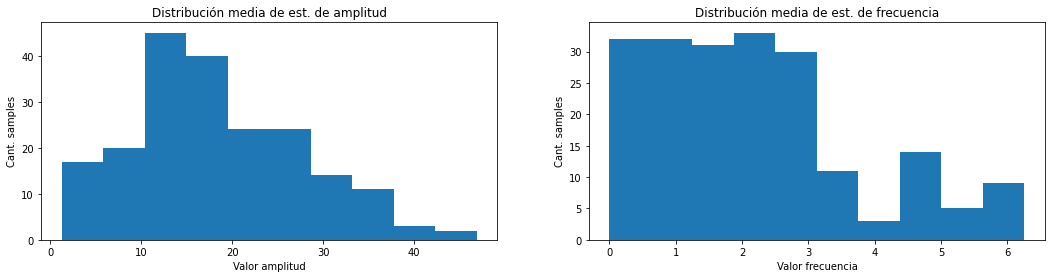

[SNR 10.000 - ventana blackmanharris]
Sesgo amplitud: 19.44, Varianza amplitud: 118.673
Sesgo frecuencia: 0.27 π, Varianza frecuencia: 2.646
--------


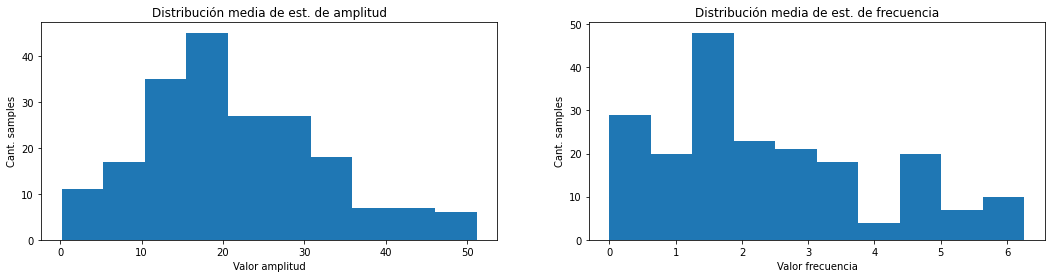

[SNR 10.000 - ventana cosine]
Sesgo amplitud: 32.85, Varianza amplitud: 345.273
Sesgo frecuencia: 0.34 π, Varianza frecuencia: 2.455
--------


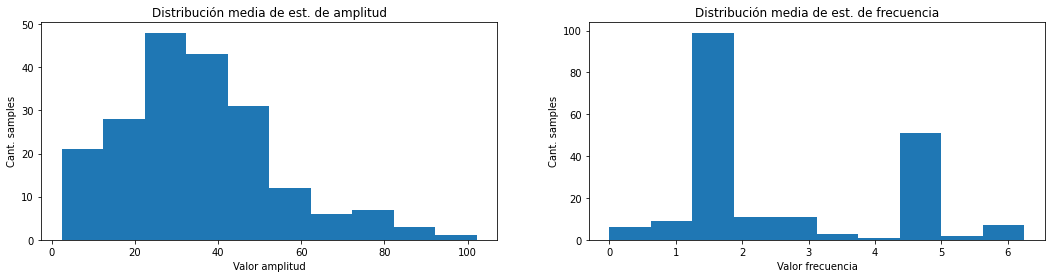

In [265]:
for indice_SNR, snr in enumerate(SNR_lin): # Recorro para todos los valores de SNR (3dB y 10dB en este caso)
    print(f"\nSNR = {SNR_dB[indice_SNR]} dB")

    # Calculo la sigma del ruido de tal forma que la potencia de la señal senoidal sea 1 W
    P_signal = 1
    P_noise = P_signal / snr
    sigma = np.sqrt(P_noise)  # sigma del ruido blanco gaussiano

    estimaciones_amp = [[] for _ in arr_W]     # Matriz de 4x200 para las 200 realizaciones de cada tipo de ventana
    estimaciones_freq = [[] for _ in arr_W]

    for _ in range(cant_realizaciones): # Bucle de 200 veces, no me interesa el indice por eso el _

        # Re declaro el array de variables aleatorias para cada realizacion
        fr = np.random.uniform(-2, 2, N)
        omega1 = omega0 + fr * ((2*np.pi) / N)
        na = np.random.normal(0, sigma, N)
        x = a0 * np.sin(omega1*k) + na      # Re-obtengo la señal X con nuevas variables aleatorias

        for i in range(len(arr_W)): # Estimo aplitud y frecuencia con cada ventana para la realizacion x de 200
            w = arr_W[i]
            amplitud = estimar_amplitud(x, w)
            frecuencia = estimar_frecuencia(x, w)

            estimaciones_amp[i].append(amplitud)
            estimaciones_freq[i].append(frecuencia)

#
#   CALCULO DE MEDIA Y VARIANZA E IMPRESION DE TABLA
#
    for indice_W in range(len(arr_W)):
        estimaciones_amp[indice_W] = np.array(estimaciones_amp[indice_W])
        estimaciones_freq[indice_W] = np.array(estimaciones_freq[indice_W])

        # Sesgo y varianza de amplitud
        mu_amp = np.mean(estimaciones_amp[indice_W])
        sesgo_amp = mu_amp - a0
        varianza_amp = np.mean((estimaciones_amp[indice_W] - mu_amp)**2)

        # Sesgo y varianza de frecuencia
        mu_freq = np.mean(estimaciones_freq[indice_W])
        sesgo_freq = mu_freq - omega0
        varianza_freq = np.mean((estimaciones_freq[indice_W] - mu_freq)**2)

        print(f"[SNR {snr:.3f} - ventana {arr_titulos_W[indice_W]}]")
        print(f"Sesgo amplitud: {sesgo_amp:.2f}, Varianza amplitud: {varianza_amp:.3f}")
        print(f"Sesgo frecuencia: {sesgo_freq/np.pi:.2f} π, Varianza frecuencia: {varianza_freq:.3f}")
        print("--------")

        plt.figure(figsize=(18, 4))
        plt.subplot(1,2,1)
        plt.hist(estimaciones_amp[indice_W], 10); plt.title("Distribución media de est. de amplitud"); plt.xlabel("Valor amplitud"); plt.ylabel("Cant. samples")
        plt.subplot(1,2,2)
        plt.hist(estimaciones_freq[indice_W], 10); plt.title("Distribución media de est. de frecuencia"); plt.xlabel("Valor frecuencia"); plt.ylabel("Cant. samples")
        plt.show()

## Bonus
- 💎 Analice el efecto del zero-padding para el estimador Ω^1
 
- 🤯 Proponga estimadores alternativos para frecuencia y amplitud de la senoidal y repita el experimento.

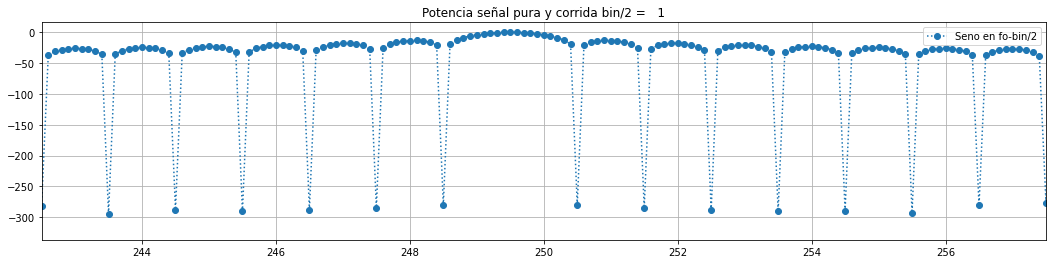

In [266]:
fs = 1000       # Frecuencia de muestreo [Hz]
N = fs          # cantidad de muestras
fo = fs/4       # [Hz]

Vmax = np.sqrt(2) #[Volts]
df = fs/N # resolución espectral

bin = fs/N

tt = np.arange(N) / fs
s_puro = Vmax * np.sin(tt*2*np.pi*fo)
s_var = Vmax * np.sin(tt*2*np.pi*(fo-(bin/2)))
sen_arr = 0
for i in range(20):
    sen_arr += Vmax * np.sin(tt*2*np.pi*(fo-(i*bin/2)))

s_var = np.concatenate((np.zeros(N*9), s_var))
ff = np.arange(0,fs,df/10) # 10 porque aumente por 10 el N
#ff = np.arange(0,fs,df)
fft_s = fft(s_puro) / N
fft_svar = fft(s_var) / N
fft_arr = fft(sen_arr) / N

plt.figure(figsize=(18, 4))
#plt.plot(ff, 20*np.log10(np.abs(fft_s)*np.sqrt(2)), ':x', label='Seno en fo',)
plt.plot(ff, 20*np.log10(np.abs(fft_svar)*np.sqrt(2)), ':o', label='Seno en fo-bin/2')
#plt.plot(ff, 20*np.log10(np.abs(fft_arr)*np.sqrt(2)), label='Sen arr')
plt.legend(); plt.xlim(fo*0.97,fo*1.03);plt.grid();plt.title("Potencia señal pura y corrida bin/2 = {:3.0f}".format(bin))
plt.show()